In [1]:
# Import my code
#from tensorfactorization.poisson import *
from tensorfactorization.multiplicative import *
from tensorfactorization.poisson import *

In [2]:
import tensorly as tl
import numpy as np
import torch
import math
import time
import random
import matplotlib.pyplot as plt
from skimage import data

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from dataclasses import dataclass, field
from typing import List

import copy # import copy so that we can do deep copys

import pickle # use pickle to save results to disk

In [3]:
def random_cp_with_noise(dimensions, F, noise_scaling=0.1, context={}):
    """
    Create a random CP tensor with some added noise
    """
    true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
    noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
    X = true_solution + noise
    return X

In [4]:
def create_initial_data(X, F):
    """
    Create random initial A_ns for our algorithms
    """
    N = X.ndim # get dimension of X
    X_shape = X.shape
    # initialize A_j with random positive values if it was not given
    A_ns = []
    for i in range(N):
        # we use random.random_tensor as it returns a tensor
        A_ns.append(tl.random.random_tensor((X_shape[i], F), **tl.context(X)))
    return A_ns

# Testing Geometric Poisson Algorithm

In [5]:
# first test numpy backend
tl.set_backend('numpy')

tensor = random_cp_with_noise((10, 10, 10), 2)
print(tl.context(tensor))

{'dtype': dtype('float64')}



 
 Update_approximation_everytime = False 
 

took 21.899281978607178 seconds with final error 0.09514987246173605

 
 Update_approximation_everytime = True 
 

took 5.6650004386901855 seconds with final error 0.09470593639271388


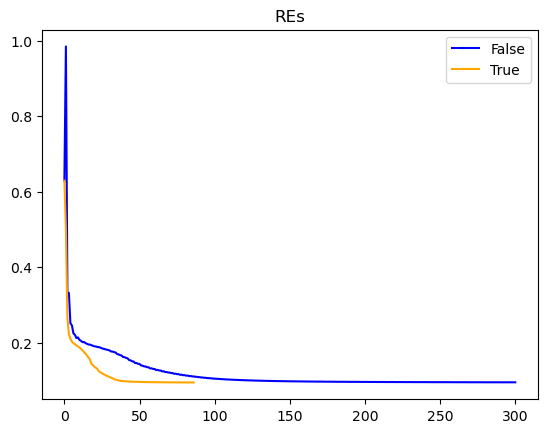

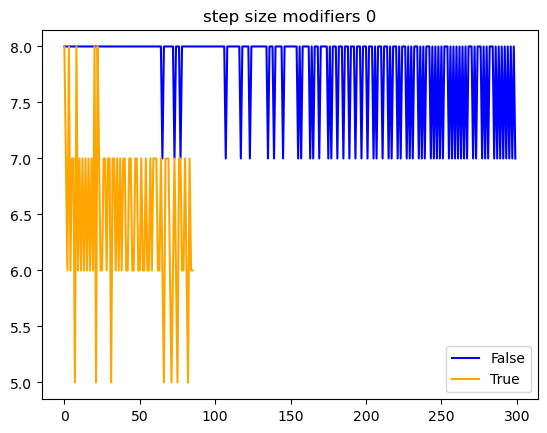

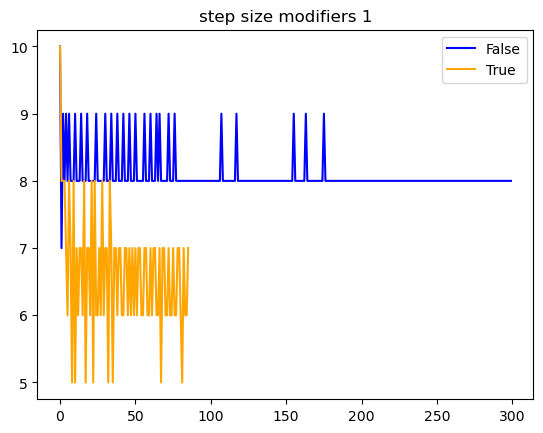

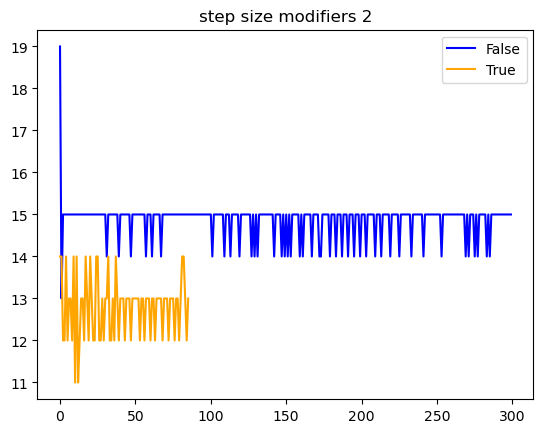

In [8]:
# first lets compare update_approximation_everytime
dimension = (200, 200, 3)
F = 3
max_iter = 300
verbose = False

tensor = random_cp_with_noise(dimension, F)
# create initial data for both
initial_A_ns = create_initial_data(tensor, F)

# Without update_approximation_everytime
start = time.time()
_, RE_false, approx_false, step_size_modifiers_false = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=False, initial_A_ns=initial_A_ns)
end = time.time()
time_false = end - start
print("\n \n Update_approximation_everytime = False \n \n")
print("took " + str(time_false) + " seconds with final error " + str(RE_false[-1]))

# with update_approximation_everytime
start = time.time()
_, RE_true, approx_true, step_size_modifiers_true = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=verbose, update_approximation_everytime=True, initial_A_ns=initial_A_ns)
end = time.time()
time_true = end - start
print("\n \n Update_approximation_everytime = True \n \n")
print("took " + str(time_true) + " seconds with final error " + str(RE_true[-1]))


plt.plot(RE_false, label="False", color="blue")
plt.plot(RE_true, label="True", color="orange")
plt.title("REs")
plt.legend()
plt.show()

for n in range(F):
    plt.plot(step_size_modifiers_false[n], label="False", color="blue")
    plt.plot(step_size_modifiers_true[n], label="True", color="orange")
    plt.title("step size modifiers " + str(n))
    plt.legend()
    plt.show()

In [21]:
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
tensor = random_cp_with_noise((10, 10, 10), 2, context=context)
print(tl.context(tensor))

{'dtype': torch.float32, 'device': device(type='cuda', index=0), 'requires_grad': False}


Time for my implementation is: 0.0012240354984874007 seconds, in 478 iterations
Time for Tensorly implementation is: 0.002480239979379726 seconds, in 343 iterations


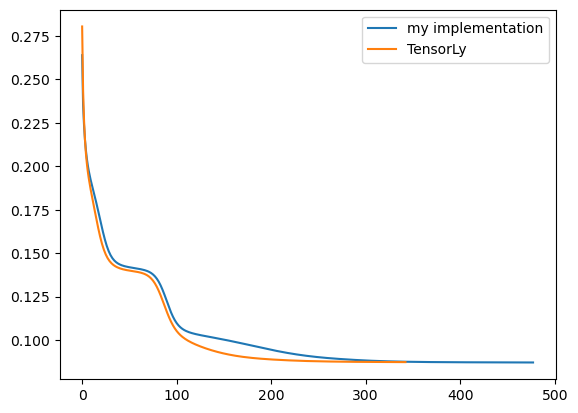

In [22]:
# comparing my multiplicative and TensorLys, as they are the same algorithm
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
X = random_cp_with_noise((300, 300, 3), 3, context=context)
F = 3

# first check my implementation
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
RE_mult.pop(0)
print("Time for my implementation is: " + str((end-start)/len(RE_mult)) + " seconds, in " + str(len(RE_mult)) + " iterations")

start = time.time()
_, RE_tensorly = tl.decomposition.non_negative_parafac(X, F, init='random', n_iter_max=1000, return_errors=True)
end = time.time()
print("Time for Tensorly implementation is: " + str((end-start)/len(RE_tensorly)) + " seconds, in " + str(len(RE_tensorly)) + " iterations")

plt.plot([value.cpu() for value in RE_mult], label="my implementation")
plt.plot([value.cpu() for value in RE_tensorly], label="TensorLy")
plt.legend()
plt.show()

In [3]:
x = np.array([1.0, 2.0, 3.0, 4.0])
G = np.diag(1.0/x)
G_inv = np.diag(x)
print(G_inv)
dF = np.array([1.0, 2.0, 3.0, 4.0])
print(np.sum(dF * G_inv@dF))
print(np.sum(dF * x * dF))

A = np.random.rand(2,3)
dF = np.random.rand(2, 3)
print(tl.sum(dF * A * dF))
#print(
step_size_modifiers = []
for i in range(3):
    step_size_modifiers.append([])
print(step_size_modifiers)

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]]
100.0
100.0
0.5868339027092577
[[], [], []]


In [4]:
tensor = tl.random.random_tensor((10, 10))
tl.context(tensor)
tl.set_backend('pytorch')
print(tl.get_backend())
torch.cuda.is_available()

pytorch


True

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(


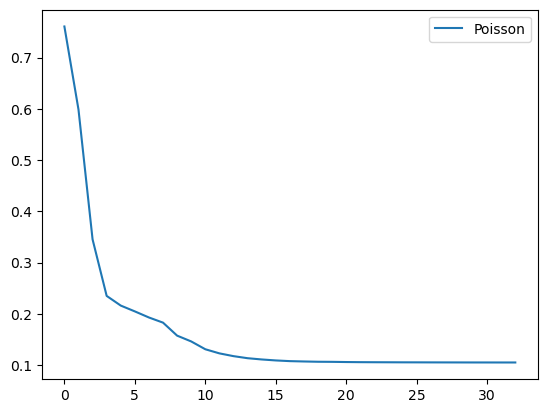

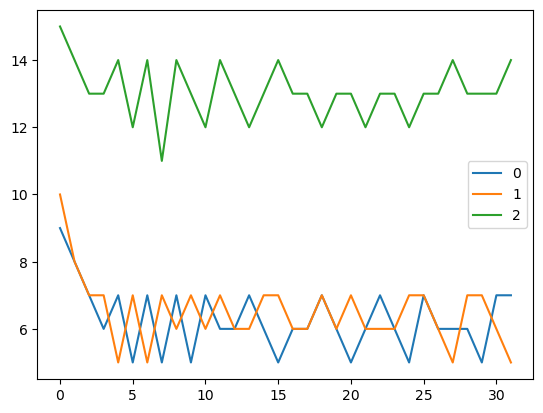

In [123]:
# Testing just poisson algo
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise

start = time.time()
A_ns, RE_poisson, approx_poisson, step_size_modifiers = tensor_factorization_cp_poisson(X, F, max_iter=100, detailed=True, verbose=False)
end = time.time()
plt.plot(RE_poisson, label="Poisson")
plt.legend()
plt.show()

for n, modifiers in enumerate(step_size_modifiers):
    plt.plot(modifiers, label=n)
plt.legend()
plt.show()

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(
C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Poisson algorithm took 6.4189324378967285 seconds with 105 iterations and had final error of 25.767369394965097
Multiplicative algorithm took 4.418255090713501 seconds with 674 iterations and had final error of 25.68528964058915
Multiplicative Poisson algorithm took 7.118511199951172 seconds with 560 iterations and had final error of 25.787136093818976
Muliplicative algorithm was 1.4528206964302144 times faster in total
Muliplicative algorithm was 9.40142623747629 times faster per iteration
Muliplicative Poisson algorithm was 4.846766533700414 times faster per iteration


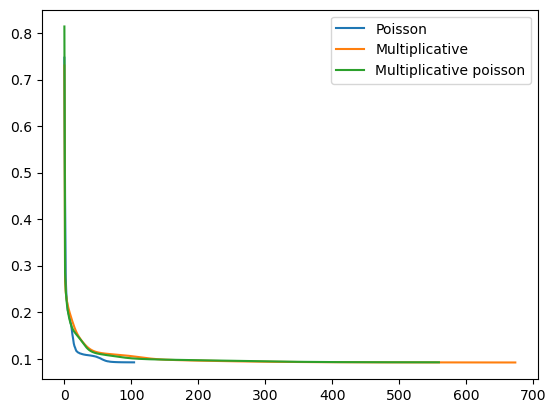

In [3]:
# Comparing on CPU
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 4
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
time_per_iteration_mult_poisson = time_multiplicative_poisson / (len(RE_mult_poisson) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")
print("Muliplicative Poisson algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult_poisson) + " times faster per iteration")
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.plot(RE_mult_poisson, label="Multiplicative poisson")
plt.legend()
plt.show()

Poisson algorithm took 0.49431729316711426 seconds with 57 iterations and had final error of tensor(24.4625, device='cuda:0')
Multiplicative algorithm took 0.40400099754333496 seconds with 354 iterations and had final error of tensor(24.1888, device='cuda:0')
Multiplicative Poisson algorithm took 0.23252534866333008 seconds with 154 iterations and had final error of tensor(24.4685, device='cuda:0')
Muliplicative algorithm was 1.2235546351939182 times faster in total
Muliplicative algorithm was 7.7127640397045205 times faster per iteration


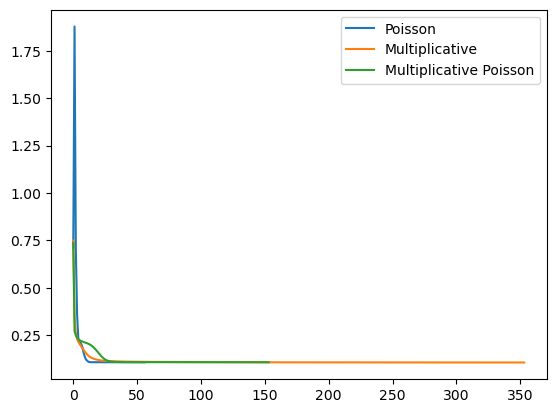

In [4]:
# Comparing on GPU with pytorch
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")

plt.plot([value.cpu() for value in RE_poisson], label="Poisson")
plt.plot([value.cpu() for value in RE_mult], label="Multiplicative")
plt.plot([value.cpu() for value in RE_mult_poisson], label="Multiplicative Poisson")
plt.legend()
plt.show()

In [6]:
A = [2, 1, 2, ]
len(A)

3